In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader, random_split

cudnn.benchmark = True
plt.ion()

In [49]:
from mydata import MyDataset
from utils import encode_labels

# Data augmentation and normalization for training
# Just normalization for validation


data_dir = 'datasets/symbols.npz'
data = np.load(data_dir)
# print(data.files)
images = data['images']
labels = data['labels']
# print(images.dtype)
# print(images.shape)
# print(labels.shape)

# class_names = np.unique(labels)
# class_nums = np.arange(0, class_names.shape[0])
# print(class_nums)
# labels_nums = np.array([np.where(class_names == l)[0][0] for l in labels])

class_names, labels_nums = encode_labels(labels)
    
# print(labels_nums.shape)

images_tensor = torch.tensor(images).float()

# Calculate the mean and standard deviation
mean = images_tensor.mean()
std = images_tensor.std()

data_transforms = {
    'train': transforms.Compose([ # Add in transforms if needed, and add test set
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


# class MyDataset(Dataset):
#     def __init__(self, images, labels, transforms=None):
#         self.images = images
#         self.labels = labels
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = self.images[idx]
#         label = self.labels[idx]
#         if self.transforms:
#             image = self.transforms(image)
#         return image, label


dataset = MyDataset(images, labels_nums, transforms=data_transforms['train'])
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
}
dataset_sizes = {x: len(dataset) for x in ['train', 'val']}
class_names = np.unique(labels)
# print(images)
# print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<class 'torch.Tensor'>


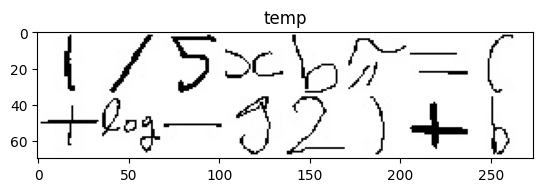

In [50]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(type(classes))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title="temp")

In [65]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = np.repeat(inputs, 3, axis=1)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [66]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [67]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# Reset the weights of the last layer (fc)
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
# model_ft.fc.reset_parameters() 

# BIG NOTE!!!!!!!!!!!!!!!!!!
# mihir had this reset_parameters thingy but id what it does so i just copied the linear layer from the pytorch website

# Reset the weights of the second last layer (layer4)
for layer in model_ft.layer4.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [68]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 

In [ ]:
visualize_model(model_ft)